In [133]:
import numpy as np
import scipy.linalg


# Polynomial kernel
def polynomial_kernel(x, y, bias=1.5, variance=6, degree=4):
    return (bias + variance * np.dot(x, y)) ** degree


# Periodic kernel
def periodic_kernel(x, y, lengthscale=0.33, variance=1.5):
    return variance * np.exp(
        -2 * np.sin(np.pi * np.abs(x - y) / lengthscale) ** 2 / lengthscale**2
    )


# Combined kernel function
def combined_kernel(x, y):
    return polynomial_kernel(x, y) + periodic_kernel(x, y)


# Define the data function g(x)
def g(x):
    return -(np.sin(6 * np.pi * x) ** 2) + 6 * x**2 - 5 * x**4 + 2 / 3


# Generate data points
X = np.linspace(0, 1, 101)
y = g(X) + np.random.normal(0, np.sqrt(0.01), 101)

# Compute the covariance matrix K
K = np.zeros((len(X), len(X)))
for i in range(len(X)):
    for j in range(len(X)):
        K[i, j] = combined_kernel(X[i], X[j])

jitter = 1e-9  # A small constant
for i in range(len(X)):
    K[i, i] += jitter

K_1 = K

# Compute the weights
w = np.array(
    [1 / (2 * 101 + 2) if i in [0, 100] else 1 / (101 + 1) for i in range(101)]
)

# For each q_hat value, compute mean and covariance of the conditional distribution
for q_hat in [0, 5, 10]:
    mu = np.dot(K, w) * (1 / np.dot(w, np.dot(K, w))) * q_hat
    Sigma = K - np.outer(np.dot(K, w), np.dot(w, K)) * (1 / np.dot(w, np.dot(K, w)))

    # Cholesky decomposition for sampling
    L = scipy.linalg.cholesky(Sigma, lower=True)

    # Sample 5 times
    samples = [mu + np.dot(L, np.random.normal(0, 1, 101)) for _ in range(5)]


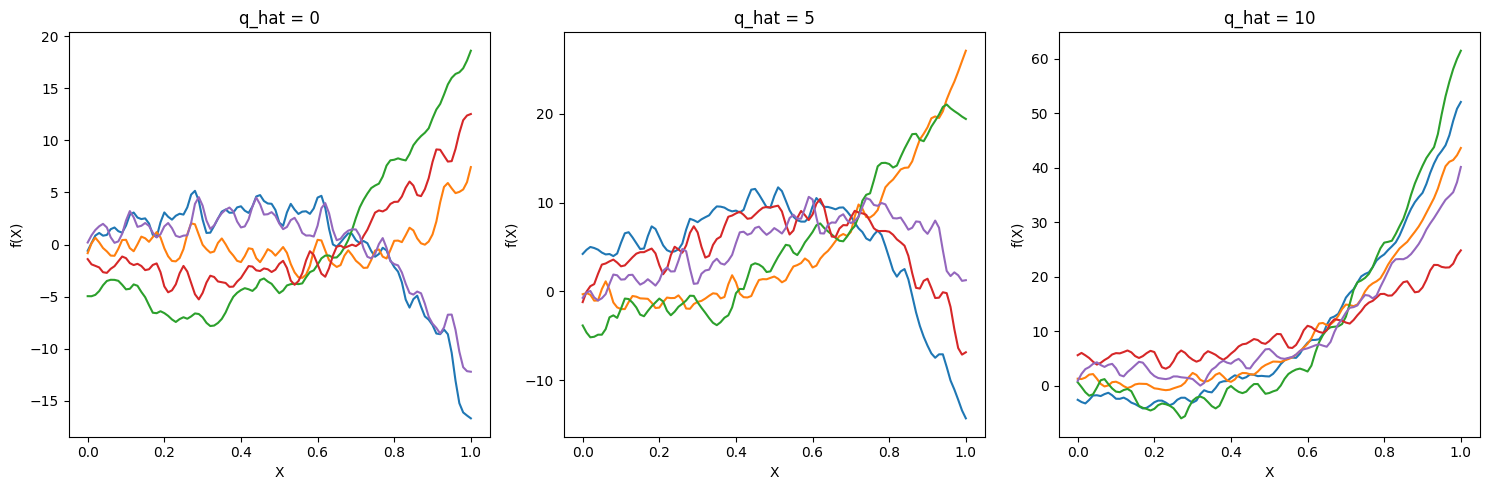

In [134]:
# Prepare the plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Sampling and plotting for each q_hat
q_hats = [0, 5, 10]
for index, q_hat in enumerate(q_hats):
    mu = np.dot(K, w) * (1 / np.dot(w, np.dot(K, w))) * q_hat
    Sigma = K - np.outer(np.dot(K, w), np.dot(w, K)) * (1 / np.dot(w, np.dot(K, w)))
    L = scipy.linalg.cholesky(
        Sigma + 1e-10 * np.eye(len(X)), lower=True
    )  # Adding jitter for numerical stability

    for _ in range(5):
        sample = mu + np.dot(L, np.random.normal(0, 1, len(X)))
        axes[index].plot(X, sample, label=f"Sample for $\hat{{q}}$={q_hat}")

    axes[index].set_title(f"q_hat = {q_hat}")
    axes[index].set_xlabel("X")
    axes[index].set_ylabel("f(X)")


plt.tight_layout()
plt.show()

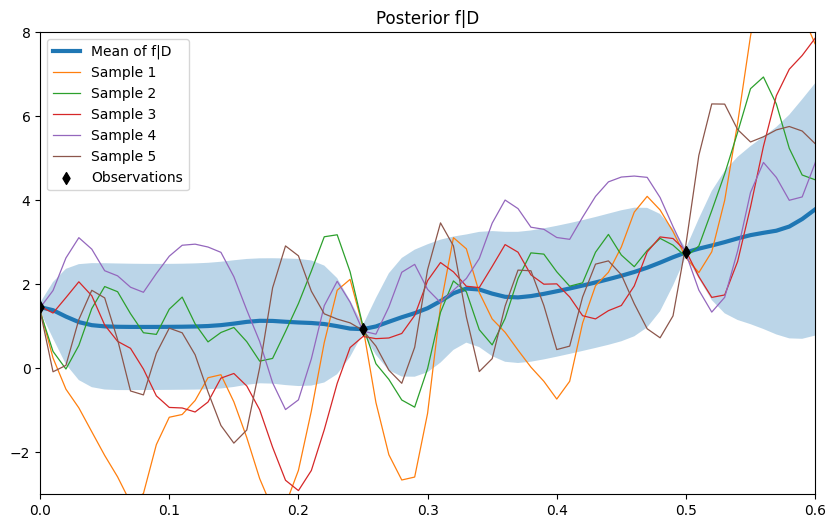

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg


# Provided functions and data
def polynomial_kernel(x, y, bias=1.5, variance=6, degree=4):
    return (bias + variance * np.dot(x, y)) ** degree


def periodic_kernel(x, y, lengthscale=0.33, variance=1.5):
    return variance * np.exp(
        -2 * np.sin(np.pi * np.abs(x - y) / lengthscale) ** 2 / lengthscale**2
    )


def combined_kernel(x, y):
    return polynomial_kernel(x, y) + periodic_kernel(x, y)


def g(x):
    return -(np.sin(6 * np.pi * x) ** 2) + 6 * x**2 - 5 * x**4 + 2 / 3


# The observation data
D_X = np.array([0, 0.25, 0.5])
D_y = np.array([1.46, 0.93, 2.76])

# Kernel matrix for the observation points
K_D = np.array([[combined_kernel(x, y) for x in D_X] for y in D_X])

# Add noise variance to the diagonal
noise_variance = 0.01
K_D += np.eye(len(D_X)) * noise_variance

# Inverse of the kernel matrix
K_D_inv = np.linalg.inv(K_D)

# Grid points
X = np.linspace(0, 1, 101)
K = np.array([[combined_kernel(x, y) for x in X] for y in X])

# Cross-covariance between grid points and observation points
K_sD = np.array([[combined_kernel(x, y) for y in D_X] for x in X])

# Posterior mean and covariance without constraint (f|D)
mu_f_D = K_sD @ K_D_inv @ D_y
Sigma_f_D = K - K_sD @ K_D_inv @ K_sD.T

# Cholesky decomposition for sampling
L_f_D = scipy.linalg.cholesky(Sigma_f_D + 1e-9 * np.eye(len(X)), lower=True)

# Sample 5 times from the posterior f|D
samples_f_D = [mu_f_D + L_f_D @ np.random.normal(size=len(X)) for _ in range(5)]
std_f_D = np.sqrt(np.diag(Sigma_f_D))
# Plotting the mean and samples for f|D
fig, ax = plt.subplots(figsize=(10, 6))

# plt.figure(figsize=(10, 6))
ax.plot(X, mu_f_D, label="Mean of f|D", linewidth=3)
ax.fill_between(X, mu_f_D - std_f_D, mu_f_D + std_f_D, alpha=0.3)
for i, sample in enumerate(samples_f_D):
    ax.plot(X, sample, lw=0.9, label=f"Sample {i+1}")
ax.scatter(D_X, D_y, color="black", marker="d", zorder=5, label="Observations")
ax.set_title("Posterior f|D")
ax.set(xlim=(0, 0.6), ylim=(-3, 8))
plt.legend()
plt.show()


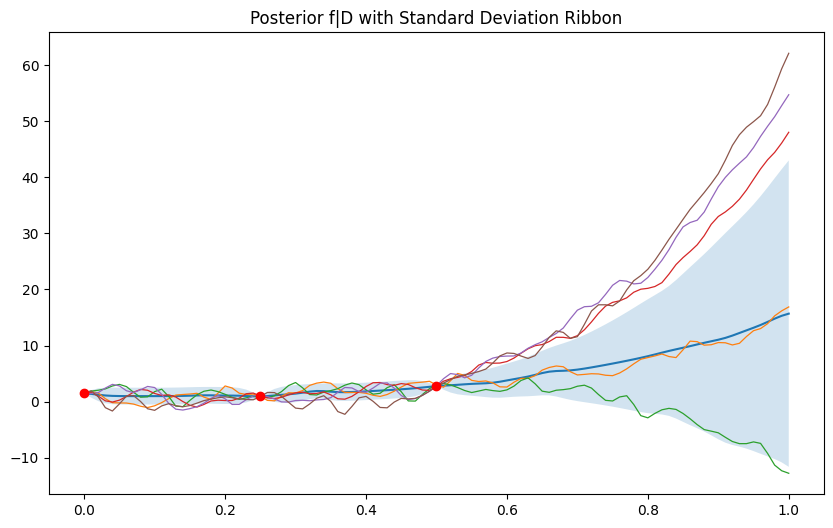

In [2]:
# Standard deviation for the posterior f|D


# Plotting the mean, samples, and the standard deviation ribbon for f|D
plt.figure(figsize=(10, 6))
plt.plot(X, mu_f_D, label="Mean of f|D")
plt.fill_between(
    X, mu_f_D - std_f_D, mu_f_D + std_f_D, alpha=0.2, label="Std. Dev. Ribbon"
)
for i, sample in enumerate(samples_f_D):
    plt.plot(
        X, sample, lw=0.9, label=f"Sample {i+1}" if i < 2 else ""
    )  # Limiting number of sample labels
plt.scatter(D_X, D_y, color="red", zorder=5, label="Observations")
plt.title("Posterior f|D with Standard Deviation Ribbon")
# plt.legend()
plt.show()


In [5]:
# Integral constraint q_hat
q_hat = 2 + 0.01

# Compute the weights for the trapezoidal rule
l = len(X)  # Number of points in the grid
w = np.array([1 / (2 * (l - 1)) if i in [0, l - 1] else 1 / (l - 1) for i in range(l)])

# Adjusting the mean and covariance for the integral constraint
# New mean
mu_q_hat = mu_f_D + (q_hat - w @ mu_f_D) / (w @ K @ w) * K @ w
# New covariance
Sigma_q_hat = Sigma_f_D - np.outer(K @ w, w @ K) / (w @ K @ w)


# Cholesky decomposition for sampling
L_q_hat = scipy.linalg.cholesky(Sigma_q_hat + 1e-4 * np.eye(len(X)), lower=True)

# Sample 5 times from the posterior f|q̂,D
samples_q_hat = [mu_q_hat + L_q_hat @ np.random.normal(size=len(X)) for _ in range(5)]

# Plotting the mean and samples for f|q̂,D
plt.figure(figsize=(10, 6))
plt.plot(X, mu_q_hat, label="Mean of f|q̂,D")
for i, sample in enumerate(samples_q_hat):
    plt.plot(X, sample, lw=0.9, label=f"Sample {i+1}")
plt.scatter(D_X, D_y, color="red", zorder=5, label="Observations")
plt.title("Posterior f|q̂,D With Integral Constraint")
plt.legend()
plt.show()


LinAlgError: 1-th leading minor of the array is not positive definite

In [7]:
# Recomputing the adjusted mean and covariance with the correct interpretation of the integral constraint

# Mean adjustment for the integral constraint
Kw = K @ w
mu_q_hat_adjusted = mu_f_D + (q_hat - np.dot(w, mu_f_D)) / np.dot(w, Kw) * Kw

# Covariance adjustment for the integral constraint
Sigma_q_hat_adjusted = Sigma_f_D - np.outer(Kw, Kw) / np.dot(w, Kw)

jitter_large = 1

# Adding a jitter to the diagonal of the adjusted covariance matrix
Sigma_q_hat_adjusted_jittered = Sigma_q_hat_adjusted + jitter_large * np.eye(len(X))

# Attempting Cholesky decomposition again
try:
    L_q_hat_adjusted = scipy.linalg.cholesky(Sigma_q_hat_adjusted_jittered, lower=True)
    # Sample 5 times from the adjusted posterior f|q̂,D
    samples_q_hat_adjusted = [
        mu_q_hat_adjusted + L_q_hat_adjusted @ np.random.normal(size=len(X))
        for _ in range(5)
    ]

    # Plotting the mean and samples for f|q̂,D with the integral constraint
    plt.figure(figsize=(10, 6))
    plt.plot(X, mu_q_hat_adjusted, label="Mean of f|q̂,D")
    for i, sample in enumerate(samples_q_hat_adjusted):
        plt.plot(X, sample, lw=0.9, label=f"Sample {i+1}")
    plt.scatter(D_X, D_y, color="red", zorder=5, label="Observations")
    plt.title("Posterior f|q̂,D With Integral Constraint (Adjusted)")
    plt.legend()
    plt.show()

    success_adjusted = True
except scipy.linalg.LinAlgError as e:
    print("An error occurred during Cholesky decomposition:", e)
    success_adjusted = False

(
    success_adjusted,
    mu_q_hat_adjusted,
    Sigma_q_hat_adjusted_jittered,
)  # Return success status and values for further use


An error occurred during Cholesky decomposition: 19-th leading minor of the array is not positive definite


(False,
 array([1.3951661 , 1.31608459, 1.15876415, 1.02126672, 0.94268176,
        0.90703226, 0.89019599, 0.87938725, 0.87031838, 0.86194274,
        0.8541128 , 0.84705309, 0.84173952, 0.84103997, 0.85033873,
        0.87321019, 0.90100436, 0.91197257, 0.8932056 , 0.85695238,
        0.82262362, 0.79188058, 0.7479364 , 0.6766764 , 0.59676472,
        0.56116935, 0.60162809, 0.6874765 , 0.76919592, 0.83815777,
        0.92732546, 1.06598551, 1.22212412, 1.30012304, 1.24287959,
        1.10830857, 0.99448356, 0.94050568, 0.93040961, 0.94008473,
        0.95675704, 0.97615051, 0.99723017, 1.01986015, 1.04427662,
        1.07146718, 1.10431134, 1.14820504, 1.20673437, 1.27126096,
        1.32004781, 1.34019735, 1.34397019, 1.35078867, 1.36232573,
        1.36180615, 1.33512693, 1.30096385, 1.31229656, 1.40087451,
        1.53604495, 1.66830083, 1.78902527, 1.93119331, 2.12410315,
        2.33575263, 2.47053517, 2.47135973, 2.39615279, 2.34299957,
        2.35101287, 2.404239  , 2.478579